1. Carregamento do dataset

In [2]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [3]:
# Caminho do ficheiro
file_path = r'C:\Users\marianas\OneDrive - Capgemini\Documents\Projeto R&D\ID Cards\November 2025\ID_8.11.1\data\qws2.txt'

# Ler todas as linhas, ignorando comentários
with open(file_path, 'r', encoding='utf-8') as f:
    lines = [line.strip() for line in f if not line.startswith('#') and line.strip()]

# Processar cada linha: separar por vírgula e corrigir colunas extra
cleaned_data = []
for line in lines:
    parts = line.split(',')
    if len(parts) > 11:
        # Junta colunas extra no último campo (WSDL Address)
        parts = parts[:10] + [','.join(parts[10:])]
    cleaned_data.append(parts)

# Criar DataFrame com nomes de colunas
columns = [
    'ResponseTime', 'Availability', 'Throughput', 'Successability', 'Reliability',
    'Compliance', 'BestPractices', 'Latency', 'Documentation', 'ServiceName', 'WSDLAddress'
]

df = pd.DataFrame(cleaned_data, columns=columns)

# Mostrar primeiras linhas e número total de linhas
print(df.head())
print("\nNúmero total de linhas:", len(df))



  ResponseTime Availability Throughput Successability Reliability Compliance  \
0       302.75           89        7.1             90          73         78   
1          482           85         16             95          73        100   
2       3321.4           89        1.4             96          73         78   
3       126.17           98         12            100          67         78   
4          107           87        1.9             95          73         89   

  BestPractices Latency Documentation        ServiceName  \
0            80  187.75            32       MAPPMatching   
1            84       1             2          Compound2   
2            80     2.6            96           USDAData   
3            82   22.77            89  GBNIRHolidayDates   
4            62   58.33            93           CasUsers   

                                         WSDLAddress  
0  http://xml.assessment.com/service/MAPPMatching...  
1  http://www.mssoapinterop.org/asmx/WSDL/compou

In [4]:

# Quick overview
print(df.shape)
print(df.info())
print(df.describe())
print(df.isnull().sum())

(2507, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2507 entries, 0 to 2506
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ResponseTime    2507 non-null   object
 1   Availability    2507 non-null   object
 2   Throughput      2507 non-null   object
 3   Successability  2507 non-null   object
 4   Reliability     2507 non-null   object
 5   Compliance      2507 non-null   object
 6   BestPractices   2507 non-null   object
 7   Latency         2507 non-null   object
 8   Documentation   2507 non-null   object
 9   ServiceName     2507 non-null   object
 10  WSDLAddress     2507 non-null   object
dtypes: object(11)
memory usage: 215.6+ KB
None
       ResponseTime Availability Throughput Successability Reliability  \
count          2507         2507       2507           2507        2507   
unique         1905           90        322             92          13   
top             115           83        

In [5]:
#convertendo colunas numéricas (são inicialmente lidas como strings)
for col in df.columns[:-2]:  # exceto ServiceName e WSDLAddress
    df[col] = pd.to_numeric(df[col], errors='coerce')

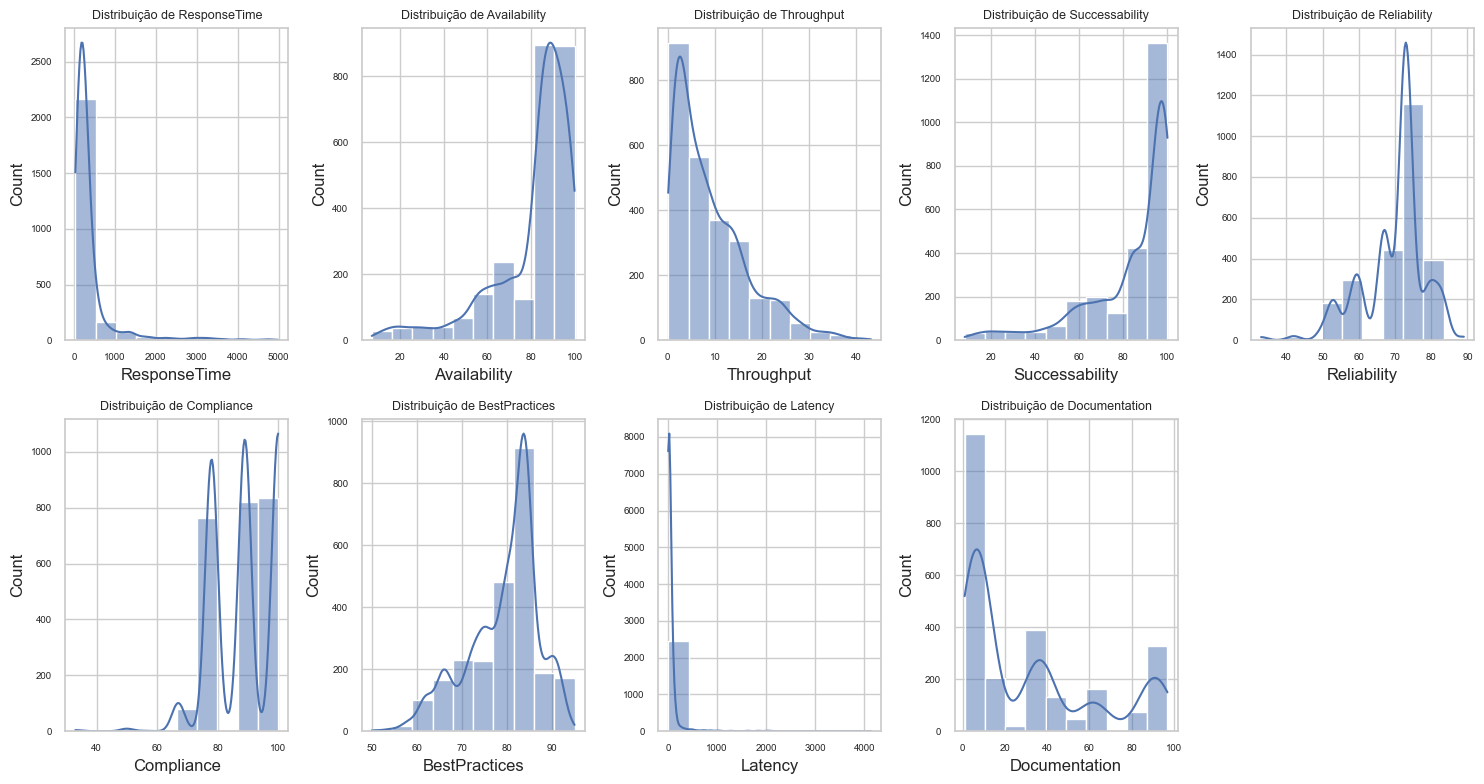

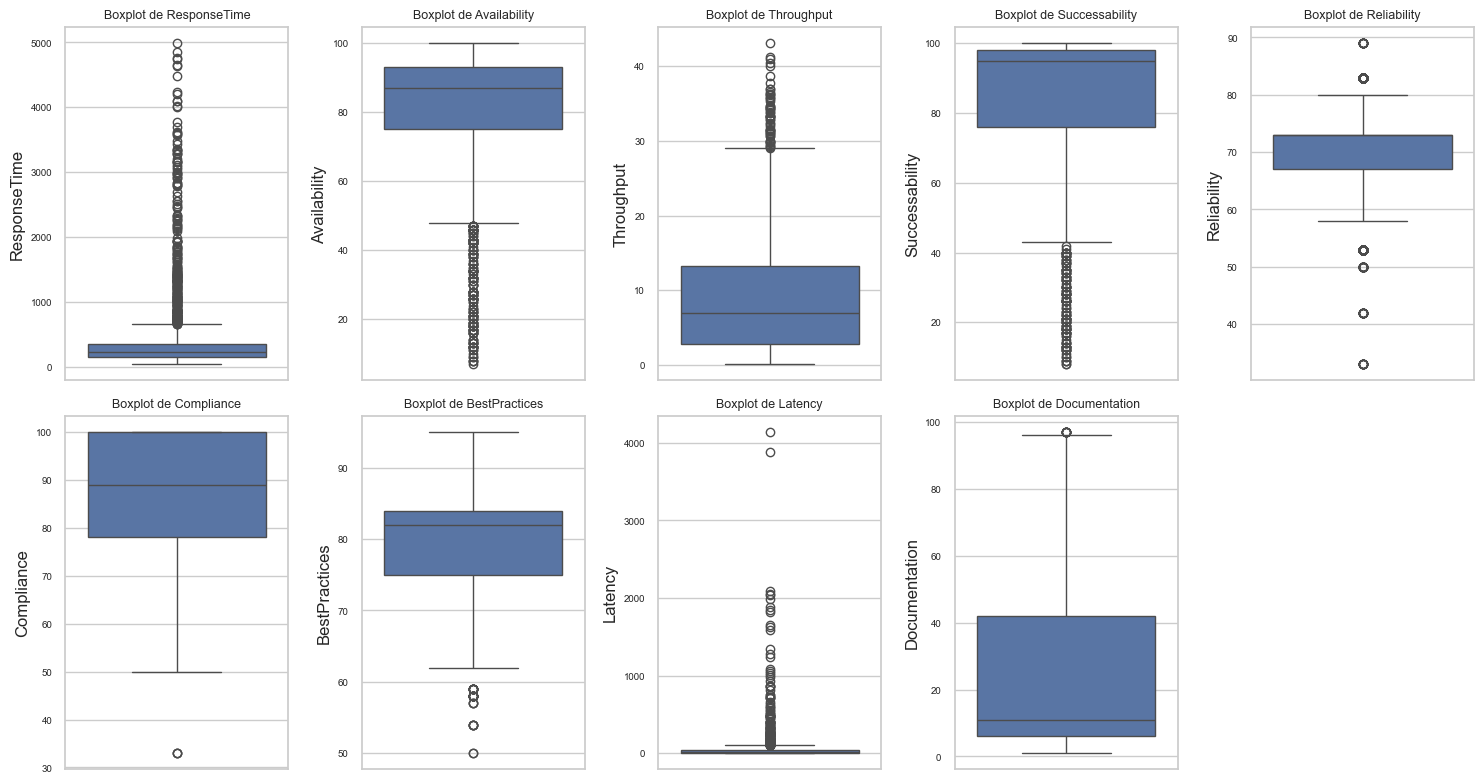

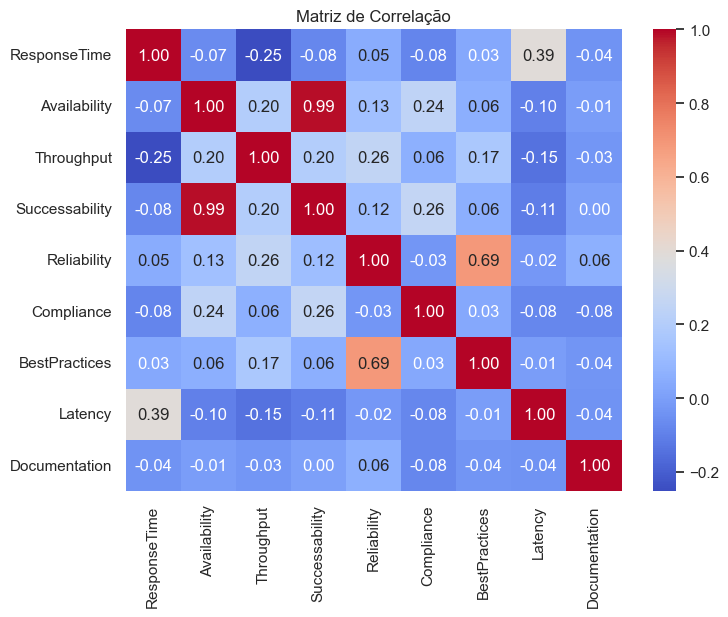

In [6]:
numeric_cols = ['ResponseTime','Availability','Throughput','Successability','Reliability','Compliance','BestPractices','Latency','Documentation']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

sns.set_theme(style="whitegrid")

# Número de colunas por linha
cols_per_row = math.ceil(len(numeric_cols)/2)

# 1. Histogramas em duas linhas
fig, axes = plt.subplots(nrows=2, ncols=cols_per_row, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=10, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribuição de {col}", fontsize=9)
    axes[i].tick_params(axis='x', labelsize=7)
    axes[i].tick_params(axis='y', labelsize=7)
# Ocultar subplots extras
for j in range(len(numeric_cols), len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

# 2. Boxplots em duas linhas
fig, axes = plt.subplots(nrows=2, ncols=cols_per_row, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot de {col}", fontsize=9)
    axes[i].tick_params(axis='y', labelsize=7)
for j in range(len(numeric_cols), len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

# 3. Matriz de correlação separada
corr = df[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

Estatísticas calculadas (Q1, Q3, IQR):
           Coluna       Q1       Q3     IQR
0    ResponseTime  142.335  348.665  206.33
1    Availability   75.000   93.000   18.00
2      Throughput    2.800   13.300   10.50
3  Successability   76.000   98.000   22.00
4     Reliability   67.000   73.000    6.00
5      Compliance   78.000  100.000   22.00
6   BestPractices   75.000   84.000    9.00
7         Latency    4.600   44.680   40.08
8   Documentation    6.000   42.000   36.00


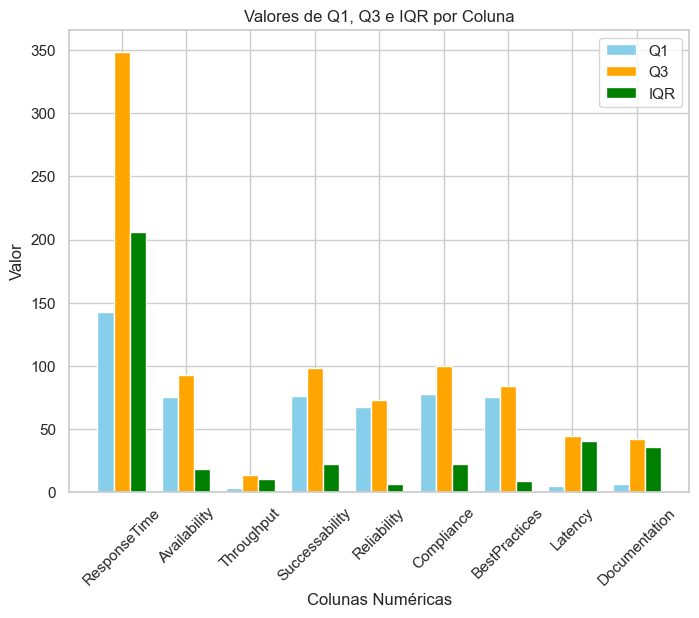

In [7]:
# ----------------------
# Selecionar colunas numéricas
# ----------------------
numeric_cols = df.select_dtypes(include='number').columns

# Calcular Q1, Q3 e IQR para cada coluna
stats = []
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    stats.append({'Coluna': col, 'Q1': Q1, 'Q3': Q3, 'IQR': IQR})

stats_df = pd.DataFrame(stats)

# ----------------------
# Gráfico de Barras (Q1, Q3, IQR) com Matplotlib
# ----------------------
plt.figure(figsize=(8, 6))
bar_width = 0.25
x = range(len(stats_df))

plt.bar([i - bar_width for i in x], stats_df['Q1'], width=bar_width, label='Q1', color='skyblue')
plt.bar(x, stats_df['Q3'], width=bar_width, label='Q3', color='orange')
plt.bar([i + bar_width for i in x], stats_df['IQR'], width=bar_width, label='IQR', color='green')

plt.xticks(x, stats_df['Coluna'], rotation=45)
plt.title('Valores de Q1, Q3 e IQR por Coluna')
plt.xlabel('Colunas Numéricas')
plt.ylabel('Valor')
plt.legend()
plt.plot


# Exibir estatísticas calculadas
print("Estatísticas calculadas (Q1, Q3, IQR):")
print(stats_df)

In [8]:
df.head()

,ResponseTime,Availability,Throughput,Successability,Reliability,Compliance,BestPractices,Latency,Documentation,ServiceName,WSDLAddress
0,302.75,89,7.1,90,73,78,80,187.75,32,MAPPMatching,http://xml.assessment.com/service/MAPPMatching...
1,482.00,85,16.0,95,73,100,84,1.00,2,Compound2,http://www.mssoapinterop.org/asmx/WSDL/compoun...
2,3321.40,89,1.4,96,73,78,80,2.60,96,USDAData,http://www.strikeiron.com/webservices/usdadata...
3,126.17,98,12.0,100,67,78,82,22.77,89,GBNIRHolidayDates,http://www.holidaywebservice.com/Holidays/GBNI...
4,107.00,87,1.9,95,73,89,62,58.33,93,CasUsers,http://galex.stsci.edu/casjobs/CasUsers.asmx?WSDL


In [9]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    print(f"Coluna: {col}")
    print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    print("-" * 40)

    # Se quiser aplicar o filtro depois:
    # df = df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]



Coluna: ResponseTime
Q1: 142.33499999999998, Q3: 348.66499999999996, IQR: 206.32999999999998
----------------------------------------
Coluna: Availability
Q1: 75.0, Q3: 93.0, IQR: 18.0
----------------------------------------
Coluna: Throughput
Q1: 2.8, Q3: 13.3, IQR: 10.5
----------------------------------------
Coluna: Successability
Q1: 76.0, Q3: 98.0, IQR: 22.0
----------------------------------------
Coluna: Reliability
Q1: 67.0, Q3: 73.0, IQR: 6.0
----------------------------------------
Coluna: Compliance
Q1: 78.0, Q3: 100.0, IQR: 22.0
----------------------------------------
Coluna: BestPractices
Q1: 75.0, Q3: 84.0, IQR: 9.0
----------------------------------------
Coluna: Latency
Q1: 4.6, Q3: 44.68, IQR: 40.08
----------------------------------------
Coluna: Documentation
Q1: 6.0, Q3: 42.0, IQR: 36.0
----------------------------------------


In [10]:
df_encoded = df.copy()

# padroniza os dados numéricos (média = 0 e desvio padrão = 1)
scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

#útil para algoritmos sensíveis à escala (regressão, clustering, redes neurais)


In [11]:
print(df_encoded)

      ResponseTime  Availability  Throughput  Successability  Reliability  \
0        -0.143703      0.420077   -0.250417        0.307201     0.375176   
1         0.173976      0.206145    0.901052        0.558474     0.375176   
2         5.206152      0.420077   -0.987875        0.608728     0.375176   
3        -0.456650      0.901424    0.383537        0.809746    -0.324650   
4        -0.490624      0.313111   -0.923186        0.558474     0.375176   
...            ...           ...         ...             ...          ...   
2502     -0.324385      0.634009   -0.858496        0.709237     0.375176   
2503     -0.580708      0.847941    0.292972        0.658983     1.541552   
2504     -0.513787     -0.061270   -0.897310       -0.195345    -0.324650   
2505     -0.491067      0.259628   -1.000813        0.558474     1.191640   
2506     -0.119334     -0.489134    0.888114       -0.597382     1.191640   

      Compliance  BestPractices   Latency  Documentation        ServiceName

Objetivo do projeto: prever WebService: Response Time, Latency, Availability (classificação)
- Prever desempenho do serviço → usar ResponseTime ou Availability
- Classificar serviços → Availability.

In [12]:
df.columns

Index(['ResponseTime', 'Availability', 'Throughput', 'Successability',
       'Reliability', 'Compliance', 'BestPractices', 'Latency',
       'Documentation', 'ServiceName', 'WSDLAddress'],
      dtype='object')

In [13]:
X = df.drop('ResponseTime', axis=1)
y = df['ResponseTime']

numeric_cols = X.select_dtypes(include=['number']).columns
categorical_cols = ['ServiceName', 'WSDLAddress']  # se existirem no X

print("Colunas numéricas:", numeric_cols.tolist())
print("Colunas categóricas:", categorical_cols)

Colunas numéricas: ['Availability', 'Throughput', 'Successability', 'Reliability', 'Compliance', 'BestPractices', 'Latency', 'Documentation']
Colunas categóricas: ['ServiceName', 'WSDLAddress']


In [14]:
# Previsão baseline: sempre a média do y_train (ou y_test)
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)

# Métricas baseline
baseline_r2 = r2_score(y_test, baseline_pred)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print("=== Baseline ===")
print(f"R²: {baseline_r2:.4f}")   # Deve ser 0.0 por definição na baseline
print(f"MAE: {baseline_mae:.4f}")
print(f"RMSE: {baseline_rmse:.4f}")

print("\n=== Modelo ===")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


'''Baseline R² = 0.0 (por definição).
Baseline MAE ≈ desvio médio absoluto do y_test.
Baseline RMSE ≈ desvio padrão do y_test.

Se o teu modelo tem:
R² > 0.0 → melhor que baseline.
MAE < baseline MAE → erros médios menores.
RMSE < baseline RMSE → menos penalização por erros grandes.'''

=== Baseline ===
R²: -0.0859
MAE: 1.1958
RMSE: 1.3520

=== Modelo ===
R²: -0.2463
MAE: 1.2676
RMSE: 1.4485


'Baseline R² = 0.0 (por definição).\nBaseline MAE ≈ desvio médio absoluto do y_test.\nBaseline RMSE ≈ desvio padrão do y_test.\n\nSe o teu modelo tem:\nR² > 0.0 → melhor que baseline.\nMAE < baseline MAE → erros médios menores.\nRMSE < baseline RMSE → menos penalização por erros grandes.'

**MODELOS REGRESSÃO**


Ranking final dos modelos:
              Modelo        R²       MAE      RMSE
1  LinearRegression -0.087117  1.179645  1.352827
4               SVR -0.246256  1.267637  1.448464
0      RandomForest -0.348015  1.301914  1.506439
3  GradientBoosting -0.482705  1.365617  1.579907
2      DecisionTree -1.122237  1.514520  1.890171

Gráficos salvos: comparacao_r2_seaborn.png, comparacao_mae_seaborn.png, comparacao_rmse_seaborn.png


C:\Users\marianas\AppData\Local\Temp\ipykernel_3392\2350160875.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modelo', y='R²', data=results_df, palette='viridis')
C:\Users\marianas\AppData\Local\Temp\ipykernel_3392\2350160875.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modelo', y='MAE', data=results_df, palette='magma')
C:\Users\marianas\AppData\Local\Temp\ipykernel_3392\2350160875.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modelo', y='RMSE', data=results_df, palette='coolwarm')


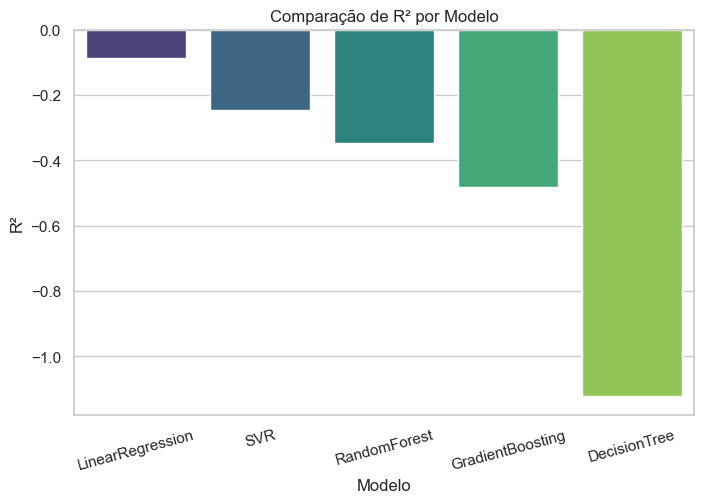

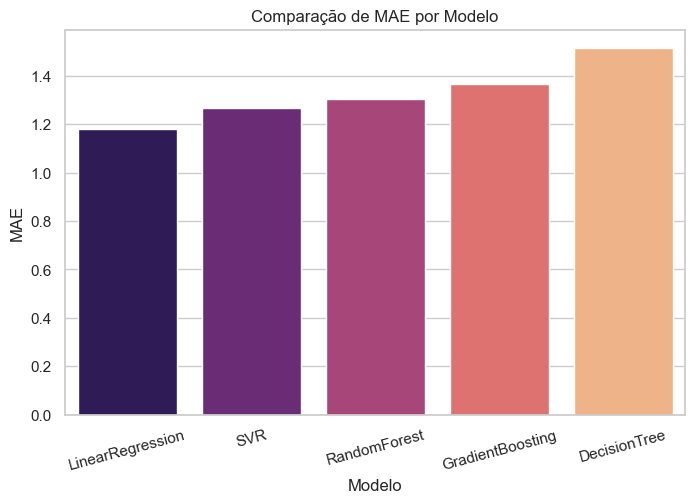

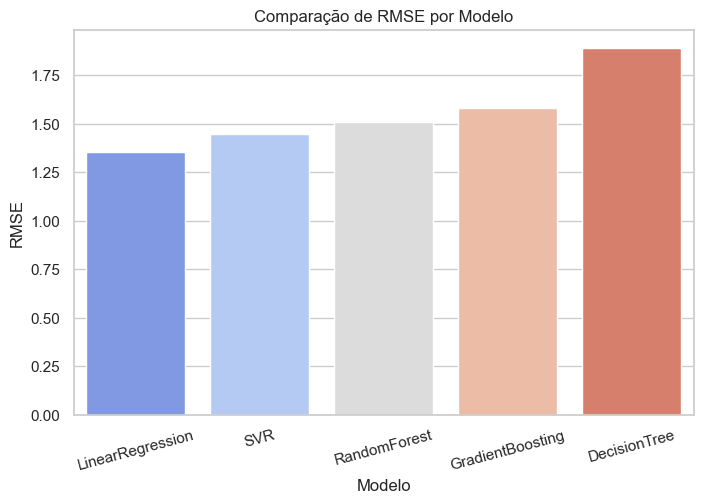

In [15]:
# =========================================
# Simulação de um DataFrame para demonstração
# =========================================
np.random.seed(42)
n = 200
df = pd.DataFrame({
    'ServiceName': np.random.choice(['ServiceA', 'ServiceB', 'ServiceC'], size=n),
    'WSDLAddress': np.random.choice(['Addr1', 'Addr2'], size=n),
    'Feature1': np.random.randn(n) * 10,
    'Feature2': np.random.randint(1, 100, size=n),
    'ResponseTime': np.random.uniform(0.5, 5.0, size=n)
})

# =========================================
# 1. Separar X e y
# =========================================
X = df.drop('ResponseTime', axis=1)
y = df['ResponseTime']

# Identificar colunas
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = [col for col in ['ServiceName', 'WSDLAddress'] if col in X.columns]

# =========================================
# 2. Dividir em treino/teste
# =========================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =========================================
# 3. Pré-processamento
# =========================================
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# =========================================
# 4. Modelos
# =========================================
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(kernel='rbf')
}

# =========================================
# 5. Treinar e avaliar
# =========================================
results = []

for name, regressor in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({'Modelo': name, 'R²': r2, 'MAE': mae, 'RMSE': rmse})

# =========================================
# 6. Organizar resultados
# =========================================
results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False)
print("\nRanking final dos modelos:\n", results_df)

# =========================================
# 7. Gráficos com Seaborn
# =========================================
sns.set_theme(style="whitegrid")

# Gráfico R²
plt.figure(figsize=(8, 5))
sns.barplot(x='Modelo', y='R²', data=results_df, palette='viridis')
plt.title('Comparação de R² por Modelo')
plt.ylabel('R²')
plt.xlabel('Modelo')
plt.xticks(rotation=15)
plt.plot

# Gráfico MAE
plt.figure(figsize=(8, 5))
sns.barplot(x='Modelo', y='MAE', data=results_df, palette='magma')
plt.title('Comparação de MAE por Modelo')
plt.ylabel('MAE')
plt.xlabel('Modelo')
plt.xticks(rotation=15)
plt.plot

# Gráfico RMSE
plt.figure(figsize=(8, 5))
sns.barplot(x='Modelo', y='RMSE', data=results_df, palette='coolwarm')
plt.title('Comparação de RMSE por Modelo')
plt.ylabel('RMSE')
plt.xlabel('Modelo')
plt.xticks(rotation=15)
plt.plot

print("\nGráficos salvos: comparacao_r2_seaborn.png, comparacao_mae_seaborn.png, comparacao_rmse_seaborn.png")

In [16]:
# Separar X e y
X = df.drop('ResponseTime', axis=1)
y = df['ResponseTime']

'''Objetivo: Dividir os dados em features (X) e target (y)
X contém todas as colunas exceto ResponseTime (variável dependente)
y contém apenas a coluna ResponseTime (o que queremos prever)'''

# Identificar colunas
numeric_cols = X.select_dtypes(include=['number']).columns
categorical_cols = [col for col in ['ServiceName', 'WSDLAddress'] if col in X.columns]


print("Colunas numéricas:", numeric_cols.tolist())
print("Colunas categóricas:", categorical_cols)

'''numeric_cols: pega todas as colunas com tipo numérico (int, float).
categorical_cols: define manualmente as colunas categóricas que interessam (ServiceName, WSDLAddress), mas só se existirem em X.

diferenças no pré-processamento:
Numéricas: imputação + normalização.
Categóricas: imputação + codificação (One-Hot Encoding).'''

# Dividir em treino/teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformadores com imputação
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())                   # normalização
])

'''Imputer: substitui valores ausentes pela mediana (robusto contra outliers). 
Neste caso não era preciso por não existirem valores ausentes
Scaler: normaliza os dados (média=0, desvio padrão=1) → importante para modelos sensíveis à escala'''

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))    # encoding
])

''' Imputer: substitui valores ausentes pela categoria mais frequente.
OneHotEncoder: transforma categorias em variáveis binárias (dummies).
handle_unknown='ignore' evita erro se aparecer categoria nova no teste.'''

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)
'''Objetivo: aplicar cada pipeline às colunas corretas.
ColumnTransformer garante que cada tipo de dado é tratado de forma adequada.'''

# Pipeline com modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

'''Junta pré-processamento + modelo num único pipeline.
RandomForestRegressor: modelo robusto para regressão, não sensível à escala, 
mas o pré-processamento ajuda na consistência.'''

# Treinar
model.fit(X_train, y_train)

# Previsões
y_pred = model.predict(X_test)

'''Usa o pipeline para transformar os dados de teste'''

# Avaliação
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

'''R²: mede quão bem o modelo explica a variabilidade (1 = perfeito).
MAE: erro médio absoluto (quanto o modelo erra em média).
RMSE: raiz do erro quadrático médio (penaliza erros grandes).'''

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

Colunas numéricas: ['Feature1', 'Feature2']
Colunas categóricas: ['ServiceName', 'WSDLAddress']
R²: -0.3480
MAE: 1.3019
RMSE: 1.5064


1. R² (Coeficiente de Determinação): Mede a proporção da variabilidade do ResponseTime explicada pelo modelo.

Intervalo:
- 1.0 → modelo perfeito.
- 0.0 → modelo não explica nada (igual a prever a média).
- < 0 → modelo pior que prever a média.

- 0.1272 significa que o modelo explica apenas 12,7% da variabilidade → muito baixo, indica que o modelo não está capturando bem os padrões.

2. MAE (Mean Absolute Error): É o erro médio absoluto entre previsão e valor real. Quanto menor, melhor.

- Ex.: se tempos típicos são 1000 ms, um erro de 192 ms pode ser aceitável.
Se tempos típicos são 300 ms, então é muito alto.

3. RMSE (Root Mean Squared Error): Penaliza mais erros grandes do que o MAE.

Intervalo também depende da escala do target.
- Se RMSE >> MAE, significa que há outliers ou erros grandes.


**Próximos passos**

Feature Engineering:
- Extrair novas variáveis (ex.: tamanho da resposta, hora do dia, tipo de operação).

Testar outros modelos:
- Gradient Boosting, XGBoost, LightGBM.

Hiperparâmetros:
- Usar GridSearchCV ou RandomizedSearchCV para ajustar n_estimators, max_depth, etc.

Analisar distribuição do target:
- Se muito assimétrica, aplicar transformação (log).

**HYPERPARAMETER RANDOM FOREST**

In [17]:


# Espaço de busca
param_grid = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt']
}

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=model,  # pipeline com preprocessor + regressor
    param_distributions=param_grid,
    n_iter=20,  # número de combinações aleatórias
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Treinar busca
search.fit(X_train, y_train)

# Melhor modelo
best_model = search.best_estimator_
print("Melhores parâmetros:", search.best_params_)

# Avaliar no teste
y_pred_best = best_model.predict(X_test)
print(f"R²: {r2_score(y_test, y_pred_best):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_best):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f}")

c:\Users\marianas\OneDrive - Capgemini\Documents\Projeto R&D\ID Cards\November 2025\ID_8.11.1\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
55 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marianas\OneDrive - Capgemini\Documents\Projeto R&D\ID Cards\November 2025\ID_8.11.1\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marianas\OneDrive - Capgemini\Documents\Projeto R&D\ID Cards\November 2025\ID_8.11.1\.venv\Lib\site-packages\sklearn\base.py", line 1365, in w

Melhores parâmetros: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 30}
R²: -0.1928
MAE: 1.2228
RMSE: 1.4170
